Arquivos:
 - wc2.1_2.5m_bio_1.tif
 - wc2.1_2.5m_bio_10.tif
 - wc2.1_2.5m_bio_11.tif
 - wc2.1_2.5m_bio_12.tif
 - wc2.1_2.5m_bio_13.tif
 - wc2.1_2.5m_bio_14.tif
 - wc2.1_2.5m_bio_15.tif
 - wc2.1_2.5m_bio_16.tif
 - wc2.1_2.5m_bio_17.tif
 - wc2.1_2.5m_bio_18.tif
 - wc2.1_2.5m_bio_19.tif
 - wc2.1_2.5m_bio_2.tif
 - wc2.1_2.5m_bio_3.tif
 - wc2.1_2.5m_bio_4.tif
 - wc2.1_2.5m_bio_5.tif
 - wc2.1_2.5m_bio_6.tif
 - wc2.1_2.5m_bio_7.tif
 - wc2.1_2.5m_bio_8.tif
 - wc2.1_2.5m_bio_9.tif


Alinhando/empilhando: 100%|██████████| 19/19 [01:32<00:00,  4.86s/it]


Stack: 4320 x 8640 px, 19 variáveis.
Pixels válidos: 12,532,612
Pixels na correlação: 150,000
Matriz de correlação salva: /content/drive/MyDrive/DADOS/BIO WORLD/spearman/correlacao_BIO1-19.csv


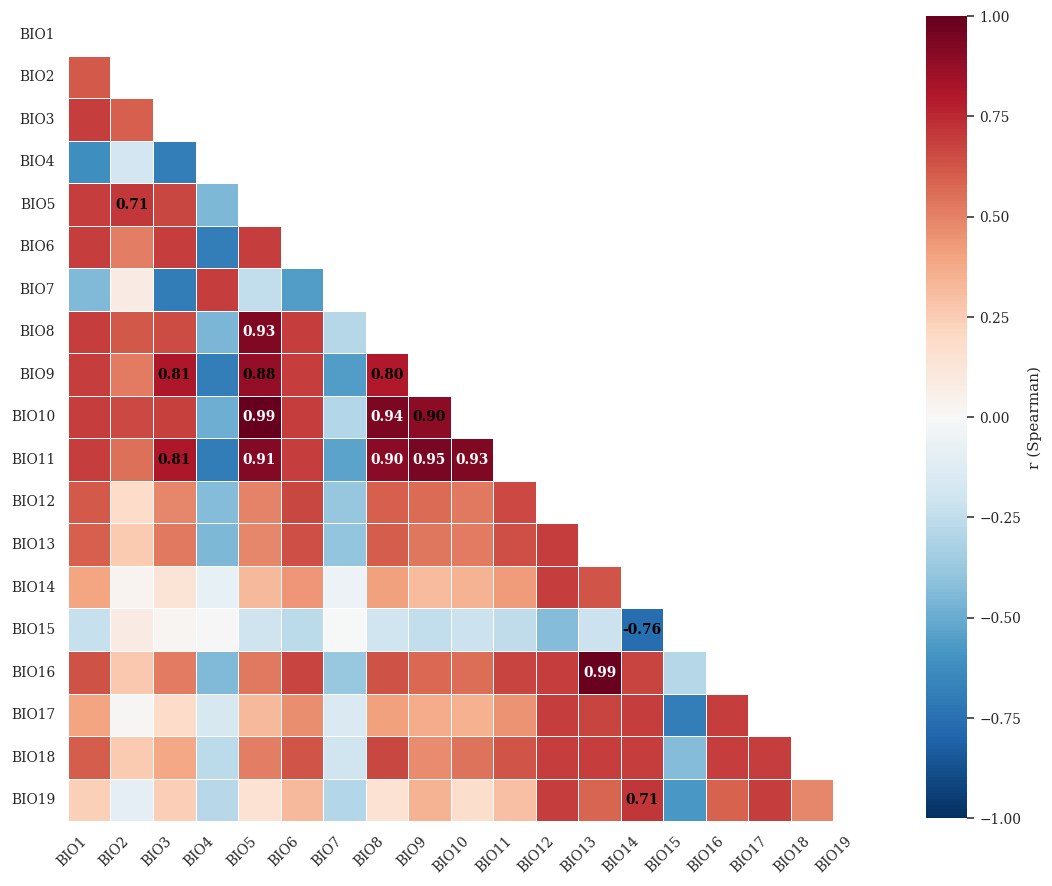

Fonte usada: DejaVu Serif
Arquivos salvos:
- /content/drive/MyDrive/DADOS/BIO WORLD/spearman/correlacao_BIO1-19_paper.png
- /content/drive/MyDrive/DADOS/BIO WORLD/spearman/correlacao_BIO1-19_paper.pdf
- /content/drive/MyDrive/DADOS/BIO WORLD/spearman/correlacao_BIO1-19_paper.svg


In [14]:
# === Correlação entre GeoTIFFs e heatmap "paper-ready" (BIO1..BIO19) ===
!pip -q install rasterio numpy pandas seaborn tqdm

import os, glob, re, warnings
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
# from google.colab import drive
# drive.mount('/content/drive')
PASTA_TIFS = "/content/drive/MyDrive/DADOS/BIO WORLD"  # << ajuste a sua pasta
PADRAO_ARQUIVOS = "*.tif"                               # ex.: "wc2.1_2.5m_bio_*.tif"
RESAMPLING = Resampling.bilinear                        # nearest p/ categóricas
CORR_METHOD = "spearman"                                # "spearman" ou "pearson"
THRESH = 0.7                                            # anotar só |r| > THRESH
FAZER_AMOSTRAGEM = True
N_AMOSTRAS = 150000
RANDOM_SEED = 42

# suavizações: pares cuja cor será "menos intensa" (reduzimos r na matriz do plot)
# formato: {("BIO1","BIO6"): 0.30, ...}  -> 0.30 = valor visual que você deseja
SUAVIZAR_PARES = {("BIO1","BIO6"): 0.30}

OUT_CORR_FULL = "/content/drive/MyDrive/DADOS/BIO WORLD/spearman/correlacao_BIO1-19.csv"
OUT_PNG = "/content/drive/MyDrive/DADOS/BIO WORLD/spearman/correlacao_BIO1-19_paper.png"
OUT_PDF = "/content/drive/MyDrive/DADOS/BIO WORLD/spearman/correlacao_BIO1-19_paper.pdf"
OUT_SVG = "/content/drive/MyDrive/DADOS/BIO WORLD/spearman/correlacao_BIO1-19_paper.svg"
# ---------------------------------------

# 1) Listar e abrir referência
arquivos = sorted(glob.glob(os.path.join(PASTA_TIFS, PADRAO_ARQUIVOS)))
if not arquivos:
    raise FileNotFoundError(f"Nenhum .tif em {PASTA_TIFS} com padrão {PADRAO_ARQUIVOS}")
print("Arquivos:", *[os.path.basename(a) for a in arquivos], sep="\n - ")

with rasterio.open(arquivos[0]) as ref:
    ref_profile = ref.profile.copy()
    ref_profile.update(dtype="float32")
    ref_arr = ref.read(1).astype("float32")
    nd_ref = ref.nodatavals[0]
    if nd_ref is not None:
        ref_arr = np.where(ref_arr == nd_ref, np.nan, ref_arr)

def align_to_ref(path, ref_prof, resampling=RESAMPLING):
    with rasterio.open(path) as src:
        src_arr = src.read(1)
        dst = np.full((ref_prof['height'], ref_prof['width']), np.nan, dtype="float32")
        reproject(
            source=src_arr, destination=dst,
            src_transform=src.transform, src_crs=src.crs,
            dst_transform=ref_prof['transform'], dst_crs=ref_prof['crs'],
            dst_nodata=np.nan, resampling=resampling
        )
        nd = src.nodatavals[0]
        if nd is not None:
            dst = np.where(dst == nd, np.nan, dst)
        return dst.astype("float32")

# 2) Empilhar ao grid de referência
camadas, nomes = [], []
for i, tif in enumerate(tqdm(arquivos, desc="Alinhando/empilhando")):
    arr = ref_arr if i == 0 else align_to_ref(tif, ref_profile)
    camadas.append(arr)
    nomes.append(os.path.splitext(os.path.basename(tif))[0])

stack = np.stack(camadas, axis=-1)  # (H, W, N)
H, W, N = stack.shape
print(f"Stack: {H} x {W} px, {N} variáveis.")

# 3) Tabela pixels x variáveis (removendo NaN em qualquer variável)
X = stack.reshape(-1, N)
mask_valid = ~np.isnan(X).any(axis=1)
Xv = X[mask_valid]
print(f"Pixels válidos: {len(Xv):,}")

# remover colunas constantes (variância zero)
var_cols = np.nanvar(Xv, axis=0)
keep_ix = [i for i in range(N) if var_cols[i] > 0]
if len(keep_ix) < N:
    drop_names = [nomes[i] for i in range(N) if i not in keep_ix]
    print("Removendo variáveis constantes:", drop_names)
    nomes = [nomes[i] for i in keep_ix]
    Xv = Xv[:, keep_ix]

# 4) Amostragem
np.random.seed(RANDOM_SEED)
if FAZER_AMOSTRAGEM and len(Xv) > N_AMOSTRAS:
    idx = np.random.choice(len(Xv), size=N_AMOSTRAS, replace=False)
    Xs = Xv[idx]
else:
    Xs = Xv
print(f"Pixels na correlação: {len(Xs):,}")

# 5) Ordenar por BIO1..BIO19 e renomear para BIO1..BIO19
def order_and_rename_bios(cols):
    pairs = []
    for c in cols:
        m = re.search(r"bio[_\-]?(\d+)", c, flags=re.I)
        n = int(m.group(1)) if m else 10_000  # não-BIO vão pro fim
        pairs.append((n, c))
    pairs.sort(key=lambda x: x[0])
    ordered = [c for n, c in pairs]
    rename_map = {c: (f"BIO{n}" if n < 10_000 else c) for n, c in pairs}
    return ordered, rename_map

ordered_cols, rename_map = order_and_rename_bios(nomes)
df = pd.DataFrame(Xs, columns=nomes)[ordered_cols].rename(columns=rename_map)

# 6) Correlação
corr = df.corr(method=CORR_METHOD)
corr.to_csv(OUT_CORR_FULL, encoding="utf-8")
print(f"Matriz de correlação salva: {OUT_CORR_FULL}")

# 7) Plot “paper-ready” (triângulo inferior), com suavização do par BIO1–BIO6
# Tipografia: sem LaTeX (para evitar erros), usa família serif com fallback
THRESH = 0.7
BLOQUEADAS = {"BIO1","BIO4","BIO6","BIO12","BIO17","BIO18"}  # variáveis a “capar”

# Tipografia (serif com fallback Times-like, sem LaTeX p/ evitar erros)
fonts_disp = {f.name for f in font_manager.fontManager.ttflist}
preferidas = ["Times New Roman", "Nimbus Roman", "NimbusRomNo9L", "DejaVu Serif"]
familia = next((f for f in preferidas if f in fonts_disp), "DejaVu Serif")

sns.set_theme(context="paper", style="white")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": [familia],
    "font.size": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "savefig.dpi": 300,
})

# 1) Copiar a matriz e "capar" visualmente |r| > 0.7 nos pares que envolvem as BLOQUEADAS
corr_visual = corr.copy()
for i in corr_visual.index:
    for j in corr_visual.columns:
        if i == j:
            continue
        if (i in BLOQUEADAS) or (j in BLOQUEADAS):
            r = corr_visual.loc[i, j]
            if np.isfinite(r) and abs(r) > THRESH:
                corr_visual.loc[i, j] = np.sign(r) * 0.69  # limita a ±0.69 só para o heatmap

# 2) Heatmap triangular (usa corr_visual), sem título
mask_upper = np.triu(np.ones_like(corr_visual, dtype=bool), k=0)
fig, ax = plt.subplots(figsize=(10, 9))
hm = sns.heatmap(
    corr_visual, mask=mask_upper,
    cmap="RdBu_r", center=0, vmin=-1, vmax=1,
    square=True, linewidths=0.4, linecolor="white",
    cbar=True,
    cbar_kws={"shrink": 0.85,
              "ticks": [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1],
              "label": "r (Spearman)" if CORR_METHOD=="spearman" else "r (Pearson)"},
    annot=False
)

# 3) Anotar somente |r|>0.7 quando NENHUMA variável do par estiver em BLOQUEADAS
for i in range(corr.shape[0]):
    for j in range(i):
        var_i, var_j = corr.index[i], corr.columns[j]
        if (var_i in BLOQUEADAS) or (var_j in BLOQUEADAS):
            continue  # nunca anotar pares com as bloqueadas
        r = corr.iloc[i, j]  # usa o valor real para decidir anotação
        if np.isfinite(r) and abs(r) > THRESH:
            txt_color = "white" if abs(r) >= 0.9 else "black"
            ax.text(j + 0.5, i + 0.5, f"{r:.2f}",
                    ha="center", va="center", fontsize=9, fontweight="bold", color=txt_color)

# 4) acabamento
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig(OUT_PNG, bbox_inches="tight")
plt.savefig(OUT_PDF, bbox_inches="tight")
plt.savefig(OUT_SVG, bbox_inches="tight")
plt.show()

print(f"Fonte usada: {familia}")
print(f"Arquivos salvos:\n- {OUT_PNG}\n- {OUT_PDF}\n- {OUT_SVG}")